In [1]:

import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import scipy.signal as ssi
import statsmodels as smo
from scipy.fft import fft, fftfreq

from keras.utils import np_utils

import random

In [11]:

class featured_tseries_df():
    ### se levanta el set full, con sus labels
    
    
    def __init__(self,filename,downsample=1,timeft=True,freqft=True,\
                 renormMx=100.0,renormMn=0.0,augment=None,diff=0,renormRowsDct=None,selfRenorm=False):
        
        self.filename=filename
        self.tab0=np.loadtxt(self.filename,delimiter=",")
        self.df0=self.tab0[:,:-1].astype("float64")
        self.labeltab=np_utils.to_categorical( self.tab0[:,-1]).astype("int") #.astype("float64")  #)## para keras
        self.labelvec=self.tab0[:,-1].astype(int)
        self.timeft=timeft
        self.freqft=freqft
        self.downsample=downsample
        
        #self.nrow,self.nt=np.shape(self.df0)
        
        self.renorm_01(renormMx,renormMn)
        #self.df0=self.df0
        #self.take_exp()
        #self.renorm_01(np.amax(self.df0) ,0.0)
    
        #self.renorm_01(renormMx,renormMn)
        #self.take_log10(0.0001)
        if selfRenorm==True:
            self.sigmas=np.std( self.df0 ,axis=0)
            self.sigma=np.mean(self.sigmas)
            self.means=np.mean(self.df0,axis=0)
            self.mean=np.mean(self.means)
            self.df0=self.df0-self.mean###self.means[np.newaxis,:]
            self.df0=self.df0/self.sigma
        if isinstance(renormRowsDct,dict):
            #self.sigmas=np.std( self.df0 ,axis=0)
            #self.sigma=np.std(self)
            #self.means=np.mean(self.df0,axis=0)
            self.df0=self.df0-renormRowsDct["mean"]###self.means[np.newaxis,:]
            self.df0=self.df0/renormRowsDct["std"]
            #self.df0=self.df0-self.sigma[np.newaxis,:]
        
        if augment is not None:
            self.data_augmentation(augment,dct={"roll":7})
        
        
        self.df_downsample()
        
        self.nrows0,self.ncols0=np.shape(self.df0)
        self.nrows1,self.ncols1=np.shape(self.df1)
        
        print("Pre downsample :", np.shape(self.df0))
        print("Post downsample :", np.shape(self.df1))
        
        if diff!=0:
            for idiff in np.arange(1,diff):
                self.df1=np.gradient( self.df1, axis=0)
        
        IDs=np.random.randint(0,high=self.nrows0,size=5)
        self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="ECGrandom.png" )
        self.plot_random_signals(self.df1,IDs,title="Post downsample",plotfilename="ECGrandomDSP.png" )
        self.plot_boxplots()
        self.df2=pd.DataFrame()
        
        if self.timeft==True:
            self.generate_timeft()
        if self.freqft==True:
            self.Fdf0=np.fft.fft(self.df0,axis=1)[:,0:self.ncols0//2]
            self.generate_freqft()
        if self.timeft or self.freqft:
            self.df2["labelvec"]=self.labelvec
            self.df2Cols=list(self.df2.columns)
        #self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="SpO2random.png" )
            self.plot_random_signals(self.FAbsdf0,IDs,title="FFT Post downsample",plotfilename="FFTecgrandomDSP.png",yscale=[0.0,10.0] )
            print("NANs:",self.df2.isna().sum().sum() )
            for col in self.df2Cols:
                print("NANs ["+col+"]:",self.df2[col].isna().sum() )
        self.df1=self.df1[:,:,np.newaxis]
        
        
    def data_augmentation(self,naug,dct):
        
        if "roll" in dct.keys():
            step0=dct["roll"]
            dfaux0=np.roll(self.df0,0,axis=0)
            lab0=self.labeltab
            vec0=self.labelvec
            for iaug in np.arange(naug):
                dfaux=np.roll(self.df0,step0*(iaug+1),axis=0)
                dfaux0=np.concatenate( (dfaux0,dfaux), axis=0)
                
                lab0=np.concatenate( (lab0,self.labeltab),axis=0)
                vec0=np.concatenate(  (vec0,self.labelvec),axis=0)
                
            self.df0=dfaux0 #np.concatenate( (self.df0,dfaux0), axis=0)
            self.labeltab=lab0    
            self.labelvec=vec0
    
    def generate_timeft(self):
        myax=1
        #### lost area 
        #netarea=np.sum(self.df1,axis=myax)
        totarea=np.sum( np.abs(self.df1),axis=myax)/np.sum( np.ones_like(self.df1[0,:]) )
        self.df2["totarea"]=totarea #netarea/totarea
        #### first derivative 
        self.df1D=np.gradient( self.df1, axis=myax)
        firstder=np.sum (  np.abs(self.df1D  ) ,axis=myax)
        self.df2["first_der"]=firstder / np.sum( np.ones_like(self.df1[0,:]) )  #totarea
        #### secder
        self.df1D2=np.gradient( self.df1D, axis=myax)
        secder=np.sum (  np.abs( self.df1D2 ) ,axis=myax)
        
        #self.df2["sec_der"]=secder /totarea
        ### amplitude 
        self.df2["amplitude"]=np.max(self.df1,axis=myax)-np.min(self.df1,axis=myax)
        
        print("NROWS in DF2",len(self.df2) )
    def generate_freqft(self):
        myax=1
        #freq = np.fft.fftfreq(tvec.shape[-1])##*2.0*np.pi/ht/omegaIR_au
        FouD1=np.fft.fft(self.df1D,axis=myax)[:,0:self.ncols1//2]
        self.FAbsdf0=np.abs(FouD1)**2 #np.fft.fft(self.df0,axis=0)
        self.FPhasdf0=np.angle(FouD1) ### son arrays 1D por cada entrada.
        self.df2["fou_maxamp"]=np.log( np.amax(self.FAbsdf0,axis=myax)/np.average(self.FAbsdf0,axis=myax) )
        self.df2["fou_freqmax"]=np.argmax(self.FAbsdf0,axis=myax).astype("float64")/np.shape(self.FAbsdf0)[1]
        
    def df_downsample(self,imethod=1):
        if self.downsample==1:
            pass
            self.df1=self.df0
        else :
            if imethod==0:
                self.df0=self.df0[:,0::self.downsample]
            elif imethod == 1 : ### genera un suavizado
                nrow,ncol=np.shape(self.df0)
                ndown=ncol//self.downsample
                self.df1=np.zeros( (nrow,ndown),dtype=float)
                
                #aux1=np.zeros()
                for idown in np.arange(self.downsample):
                    self.df1+=self.df0[:,idown::self.downsample] ### sumamos los desplazados
                self.df1/=self.downsample  ### div por el nro de subsampling
                    
    def renorm_01(self,mx,mn): ### renorm the SpO2 signal to [0,1], no centering.
        #pass
        self.df0/=(mx-mn)
        
    def take_log10(self,eps):
        self.df0=np.log10(eps+self.df0)
    def take_exp(self):
        self.df0=np.exp(self.df0)

        
    ####smo.tsa.stattools.acf()
    def plot_random_signals(self,mydf,IDs,title=" ",plotfilename=" ",yscale=[0.75,1.0]):

        nplot=len(IDs)
        linestyle_str = ["-",":","--","-."]
        linewidth=[4]
        linecol=["b","g","r","c","m","y","tab:orange","tab:blue","tab:purple","tab:grey"]
        nwidths=len(linewidth)
        nstyles=len(linestyle_str)
        ncolor=len(linecol)
        
        
        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle(title)
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('$i_t$ ', fontsize = 35)
        ax1.set_ylabel('ecg signal', fontsize = 35)
        ax4.set_xlabel('$i_t$ ', fontsize = 35)
        ax4.set_ylabel('ecg signal', fontsize = 35)        #ax2 = ax1.twiny()

        ax1.tick_params("both",labelsize=24)

        for iplt in IDs:
            ax1.plot(mydf[iplt,:],lw=linewidth[iplt%nwidths],linestyle=linestyle_str[iplt%nstyles],\
                     color=linecol[iplt%ncolor])#,marker="X",ms=12,label="Retrieved")
        #plt.tricontourf(spec[:,0],spec[:,1],spec[:,2], 50,cmap=cmpalette)

        if plotfilename !=" ":
            plt.savefig(plotfilename,bbox_inches='tight', transparent=False)
        
    def plot_boxplots(self):
        print("Balanced?")
        print(np.sum(self.labelvec)/np.shape(self.labelvec)[0])
        print( np.sum(self.labeltab,axis=0 ) )
        for col in self.df1:
            #DBbox=[]#{}#[]
            #for ilev, lev in enumerate(Levs):
            #    DBbox.append( DBNum[col].loc[DBTarg[TargVar]==lev])
            #    #DBbox[ilev]= DBNum[col].loc[DBTarg[TargVar]==lev]
            pass

        

Pre downsample : (4998, 140)
Post downsample : (4998, 140)


<ipython-input-11-c98473addd9c>:169: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-11-c98473addd9c>:169: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.5840336134453782
[2079 2919]
NROWS in DF2 4998
NANs: 0
NANs [totarea]: 0
NANs [first_der]: 0
NANs [amplitude]: 0
NANs [fou_maxamp]: 0
NANs [fou_freqmax]: 0
NANs [labelvec]: 0


<ipython-input-11-c98473addd9c>:169: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


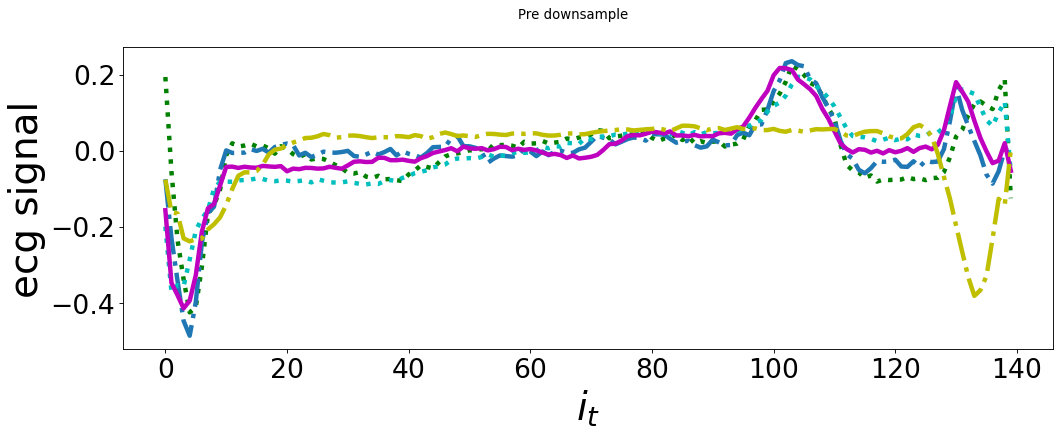

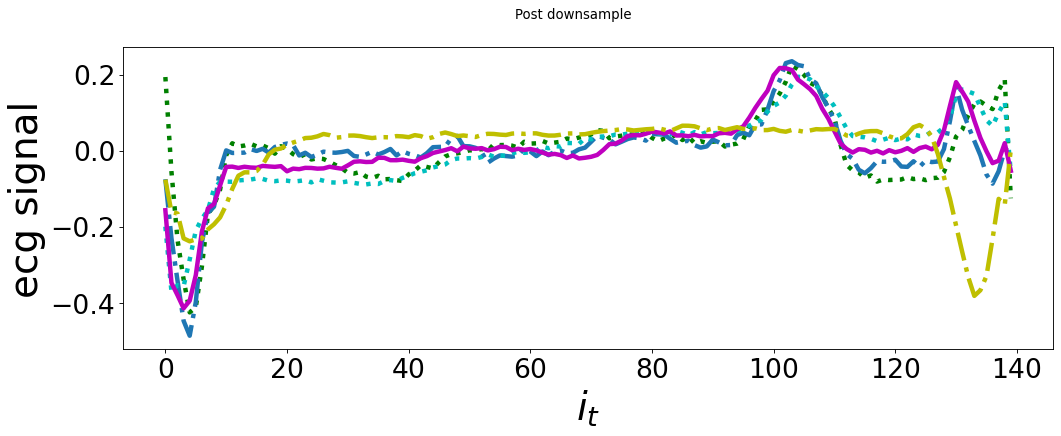

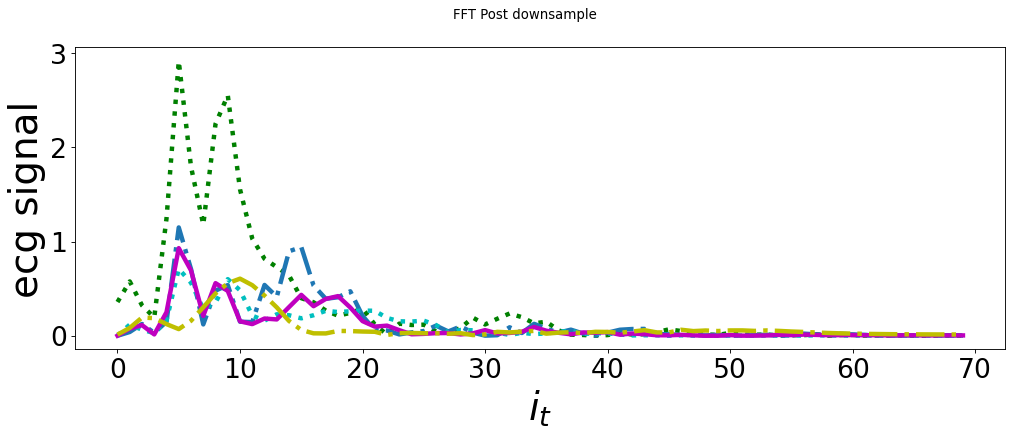

In [12]:
FullSet=featured_tseries_df("ecg.csv",downsample=1,timeft=True,freqft=True,\
     renormMx=10.0,renormMn=0.0,augment=None,diff=0,\
                renormRowsDct=None,selfRenorm=False)
        

In [13]:
myset1=FullSet.df2.drop(columns=["labelvec"])
myset2=FullSet.df2.drop(columns=["labelvec",'amplitude', 'fou_maxamp'])

setLs=[myset1,myset2]
labelLs=[FullSet.labelvec,FullSet.labelvec]

In [14]:
from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve,\
    roc_auc_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix

In [21]:
def reclassif(myset,labelvec,nclus=2):
    n_clusters = nclus
    gmm_model = GaussianMixture(n_components=n_clusters)
    gmm_model.fit(myset )


    cluster_labels = gmm_model.predict(myset)
    print(np.shape(myset))
#print(FullSet.df2)
#X = pd.DataFrame(X)
#X['cluster'] = cluster_labels
    print( np.shape(cluster_labels) )

#def plot_classif_reclassif(myset):
    print("dot product between cluster approach and original labels:")
    Nlen=len(labelvec)
    dot=np.dot( 2.0*(cluster_labels-0.5),2.0*(labelvec-0.5) )/Nlen
    print(dot)
    
    colorvec=["r","g","b","y","c","m"]
    varLs=list(myset)

    for ivarx,varx in enumerate(varLs):
        for ivary,vary in enumerate(varLs):
            if ivary <= ivarx :
                continue
            for k in range(0,n_clusters):
                data =myset[cluster_labels==k]
                plt.scatter(data[varx],data[vary],c=colorvec[k],alpha=0.1)


            plt.title("Clusters Identified by Guassian Mixture Model")    
            plt.ylabel(vary)
            plt.xlabel(varx)
            plt.show()

            for k in range(0,n_clusters):
                data = myset[labelvec==k]
                plt.scatter(data[varx],data[vary],c=colorvec[k+2],alpha=0.1)


            plt.title("Original classification")
            plt.ylabel(vary) 
            plt.xlabel(varx)
            plt.show()
    return cluster_labels

(4998, 5)
(4998,)
dot product between cluster approach and original labels:
-0.8187274909963985


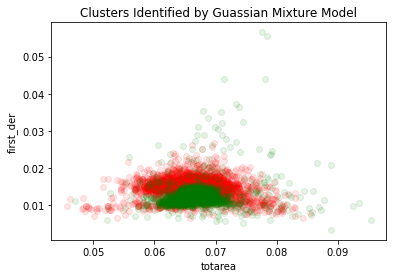

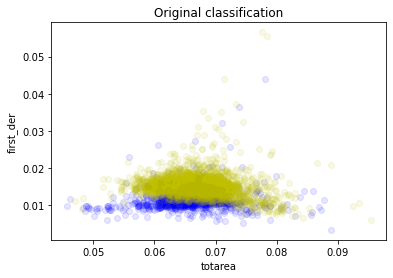

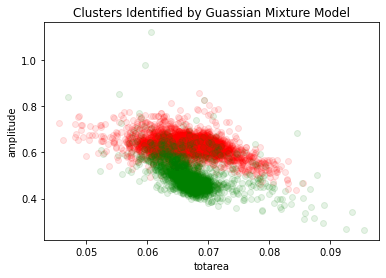

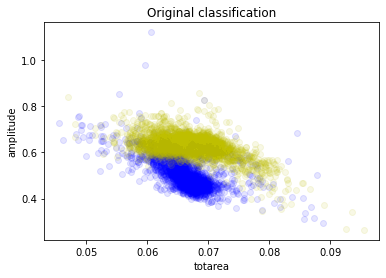

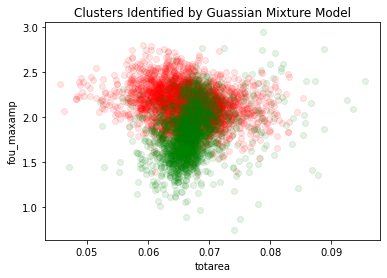

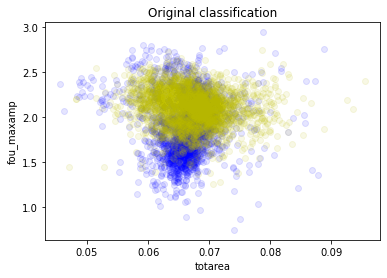

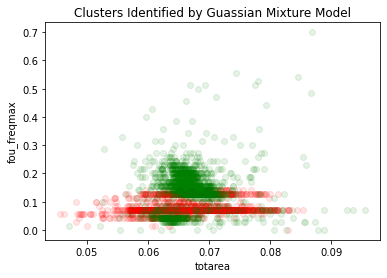

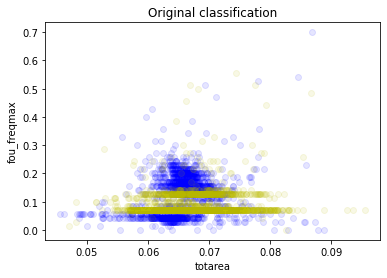

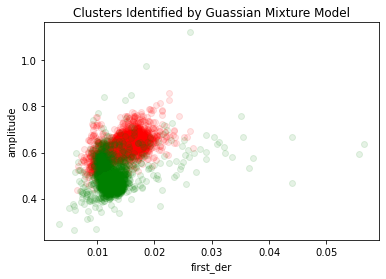

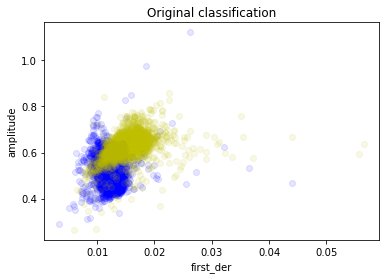

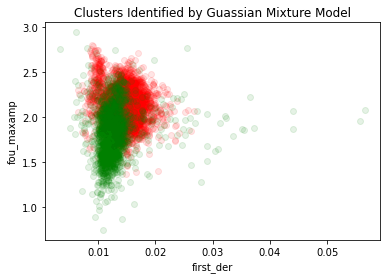

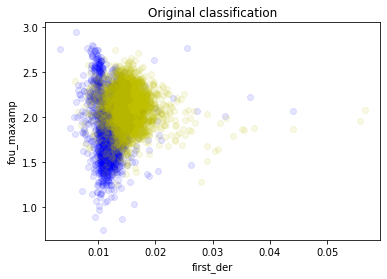

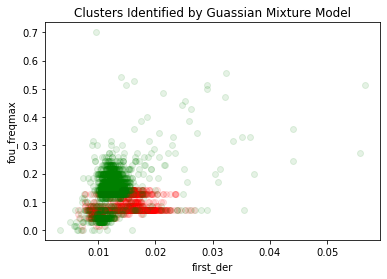

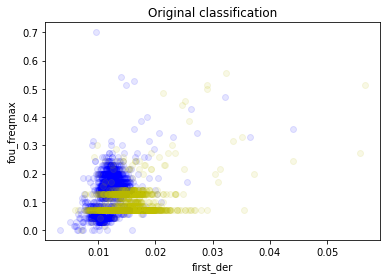

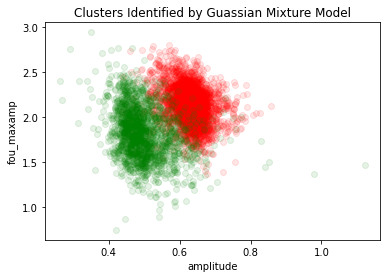

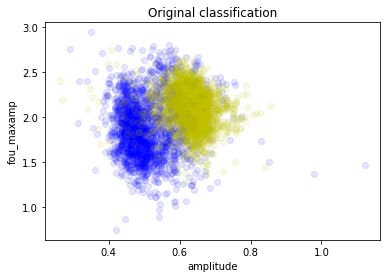

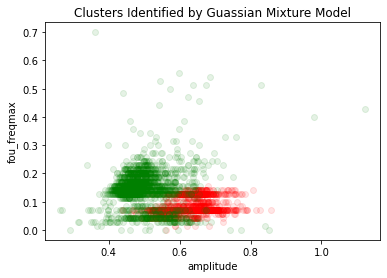

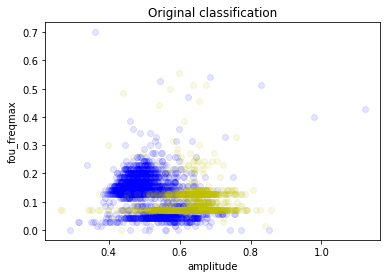

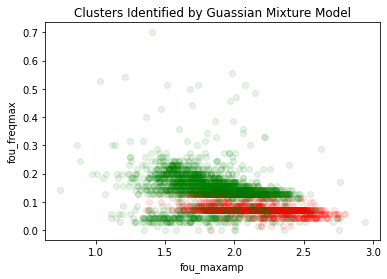

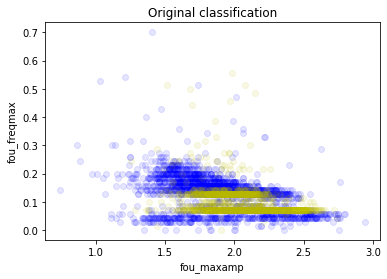

(4998, 3)
(4998,)
dot product between cluster approach and original labels:
-0.6766706682673069


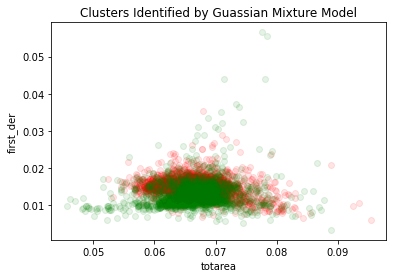

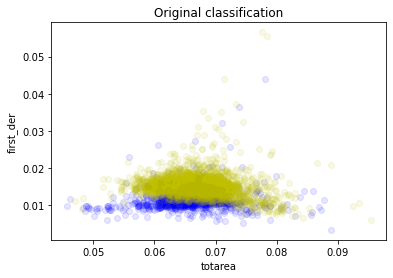

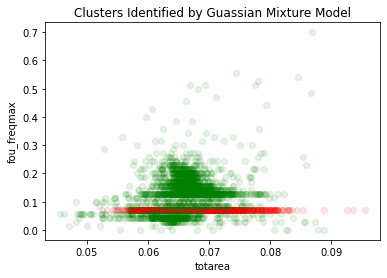

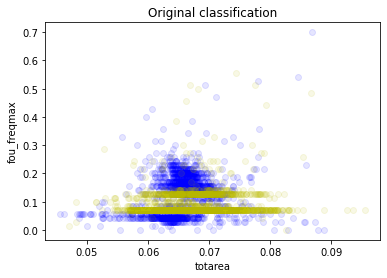

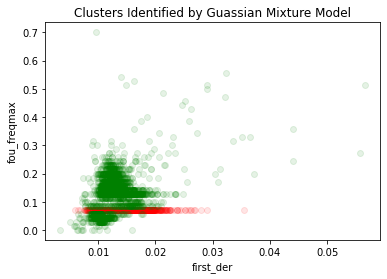

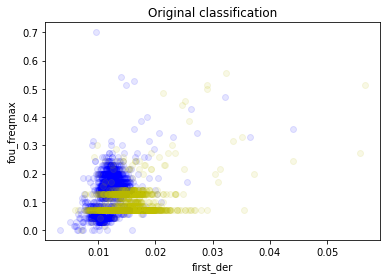

In [24]:
cluslabLs=[]
for imy,myset in enumerate(setLs):
    cluslabLs.append(reclassif(myset,labelLs[imy],nclus=2))
    #plot_classif_reclassif(myset)

In [26]:
#mydir=SepSpO2
for icl,cluster_labels in enumerate(cluslabLs):
    fset=set(cluster_labels)
    Clasificados=[]
    for val in fset:
        tempset=[]
        for ifi,fila in enumerate(FullSet.df0):
           if cluster_labels[ifi]==val:
               tempset.append(fila)

        Clasificados.append(tempset)

    fset=list(fset)
    print(fset)

    for ifs,f in enumerate(fset):
        mydir="CL"+str(icl).zfill(2)+"SepECG_"+str(f)+"/"
        cmdstr=" mkdir "+mydir
        sbp.call(cmdstr,shell=True) 
        for ivec,vec in enumerate(Clasificados[ifs]):
            np.savetxt(mydir+"ECG_"+str(f) +"_"+str(ivec).zfill(3) +".dat",vec)

[0, 1]
[0, 1]
